# Fitting a computational model of momentary well-being to trial-by-trial affect ratings

During the reinforcement learning task, participants were about their subjective feelings after every trial. Specifically, after making a choice and receiving feedback, they were asked to rate from 0 to 100 how they felt with respect to three adjectives:

1. How **happy** are you at this moment?
2. How **confident** are you feeling in your answers at this moment?
3. How **engaged** are you feeling at this moment?

In each block of sixty trials, participants were asked each question exactly twenty times. The question order was randomised in groups of three such that each participant saw each question twice every six trials, and did not receive the same question more than twice in a row. Here we demonstrate that a computational model including quantities estimated from a Q-learning model fit to task choices can relatively accurately capture trial-by-trial fluctuations in affect ratings across the entire training phase.

## Setup

### Python dependencies

Despite all the code being in R, we run it through Python (via ```ryp2```) because the model outputs work better...

In [1]:
import os
os.chdir('..')
    # may need to be run initially if working directory is the notebook folder
%load_ext rpy2.ipython

### R dependencies and data

In [2]:
%%R
remotes::install_github(
    "qdercon/pstpipeline",
    quiet = TRUE,
    upgrade = "always"
)
# install.packages(c("patchwork", "ggtext"))
cmdstanr::set_cmdstan_path("/home/qd01/.cmdstanr/cmdstan-2.31.0") 
# extrafont::loadfonts(device = "win", quiet = TRUE) 
    # required on Windows to load additional fonts
options(width = 120)

R[write to console]: CmdStan path set to: /home/qd01/.cmdstanr/cmdstan-2.31.0



In [3]:
%%R
pal <- c("#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80")
pal_contr <- c("#ffc9b5", "#95a7ce", "#987284")
pal_recovery <- c("#ffc9b5", "#648767", "#b1ddf1", "#b6b8d6", "#498c8a", "#78ffd6")

all_res_split <- readRDS("data-raw/all_res_split.RDS")
all_res <- purrr::transpose(all_res_split) |> purrr::map(dplyr::bind_rows)

# install.packages("sysfonts")
# sysfonts::font_add_google("Open Sans", "Open Sans")
# showtext::showtext_auto()

## Model fits

The computational model used here is a version of one proposed and validated by Rutledge *et al.* (2014) in [PNAS](https://www.pnas.org/doi/10.1073/pnas.1407535111). This model, specifically used to capture momentary happiness, suggests that subjective well-being at a given trial can be well-captured by a discounted (i.e., recent trials weighted higher) sum of expected values and prediction errors plus a baseline weight (i.e., intercept) term. Specifically, their proposed model is as follows,

\begin{equation*}
happiness_t = w_0 + w_1\sum_{j=1}^{t}{\gamma^{t-j}CR_j} + w_2\sum_{j=1}^{t}{\gamma^{t-j}EV_j} + w_3\sum_{j=1}^{t}{\gamma^{t-j}RPE_j},
\label{eq:rutledge2014} \tag{1}
\end{equation*}

where $t$ is the trial number, $\gamma$ is the discount or 'forgetting' factor, and $w$ the weights on each of the quantities of interest. It should be noted that in their task, rewards and losses were monetary, with the specific amounts won/lost available to participants on each trial, so the $EV$ and $RPE$ quantities could be calculated directly. In addition, there existed an option on each trial to take a "certain reward" ($CR$) rather than opt for a gamble.

In our task, meanwhile, expected values and prediction errors are not directly available to participants, but assumed to be computed nonetheless, with a dual learning-rate $Q$-learning model accounting well for individuals' choices. With our dataset, we were first able to answer a somewhat novel question: whether model-derived EVs and RPEs could similarly capture momentary fluctations in happiness during a reinforcement learning task. We also wondered whether fluctuations in the other affect nouns (confidence and engagement) could also be captured by such a model, perhaps with different weights. Lastly, we were interested if there may be any effect of cognitive distancing on weights estimated for each of the three affect nouns.

As affect ratings (when divided by 100) were between 0 and 1, we assumed that ratings on each adjective followed independent beta distributions (in a mean-precision formulation), as validated in recent work from [Forbes & Bennett (2023)](https://osf.io/m7dtw/). The model code was also partly adapted from openly shared Stan code for a hierarchical version of the above model from an independent replication of the original PNAS study by [Vanhasbroeck *et al.* (2021)](https://www.tandfonline.com/doi/full/10.1080/02699931.2021.1891863); this was extended to incorporate the single or dual learning-rate $Q$-learning model and account for the three separate questions. Noting that, overall, affect ratings declined over the course of the task (e.g., due to fatigue), in a stepwise manner by block (the first rating in a block was on average highest), we included up to two extra (linear) intercept terms to account for time elapsed, both overall since the start of the task, and since the start of a given block. Such an effect has been seen in many similar studies with momentary affect ratings, and has been recently termed ["mood drift over time"](https://www.nature.com/articles/s41562-023-01519-7). The full model is as follows,

\begin{equation*}
affect_t = w_0 + w^{o}_{1}{time(o)_t} + w^{b}_{1}{time(b)_t}+ w_2\sum_{j=1}^{t}{\gamma^{t-j}Q_j(s_j, a_j)} + w_3\sum_{j=1}^{t}{\gamma^{t-j}[reward_j - Q_j(s_j, a_j)]},
\label{eq:extended} \tag{2}
\end{equation*}

where $affect_t$ is the rating at trial $t$ (between 0 and 1), and $time(o)_t$ and $time(b)_t$ refer to time (in hours) elapsed overall until trial $t$, and time elapsed since the start of the block containing trial $t$ respectively. $Q_j(s_j, a_j)$ and $reward_j - Q_j(s_j, a_j)$ are the $Q$-learning model-derived expected value and prediction error on trial $j$. Note that, in contrast to model fits for the $Q$-learning model alone (in other notebooks), rewards are coded as 1 or -1, to allow for negative expected value estimates.

For the purposes of model comparison we fit five different variants of this model, including the original model $\eqref{eq:rutledge2014}$, extended variants with constants on trial number or block number, the original passage of time model (with $w^{o}_{1}$ alone), and the full model $\eqref{eq:extended}$. It should be noted that we use automatic differentiation variational inference ([ADVI](https://www.jmlr.org/papers/volume18/16-107/16-107.pdf)) implemented in CmdStan to fit these models throughout, due to the complexity making MCMC computationally unreasonable (i.e., 18 free parameters of interest for each individual, plus $Q$-learning model parameters and many other distributional parameters at the group- and individual-level). The models were compared using the leave-one-out information criterion with a correction for approximate inference implemented in the *loo* R package (see [this vignette](https://mc-stan.org/loo/articles/loo2-large-data.html)).

To improve stability of approximate fits, models were fit together in non-distanced and distanced participants, on ratings for all three questions together, with separate weights and decay factors assumed for each person and question.

#### A note on model fitting

Due to the high complexity of these models, they are non-trivial to fit, as they often get stuck in local maxima or otherwise fail to converge. In addition, the approximate fit method prevents us from exploring standard diagnostics; however, we show below that parameter recovery is generally excellent, and posterior predictions broadly accurate. 

Fitting these models required multiple attempts, with the general procedure as follows:
1. Begin model fitting and wait for the first evidence lower bound (ELBO) value to be outputted by the sampler. (In variational inference, we aim to maximise the ELBO, which is equivalent to minimising the KL-divergence between the approximate and the true posterior.) Sometimes the first negative ELBO value is extremely large, and these fits will generally not converge in a reasonable number of iterations; hence, we restart the sampler if the first ELBO value is (approximately) < -1,000,000.
2. Wait until the defined $\Delta$ ELBO tolerance is reached and the model converges (here, we have set the ```tol_rel_obj``` at 0.005, or half the Stan default). Again, this is not guaranteed, and the sampler may need to be restarted if this tolerance is not reached.
3. Check the outputted posterior distributions of the parameters &mdash; given the high complexity of the model, parameters will sometimes converge to having a posterior distribution with almost zero variance. Note that sometimes this is inescapeable, such as in the case of the $w^{b}_{1}$ parameter in the full model.
)

### Dual learning rate models

In [4]:
%%R
head(tibble::as_tibble(all_res$ppt_info))

# A tibble: 6 × 78
  subjID                 sessionID studyID distanced exclusion final_block_AB final_block_CD final_block_EF total_points
  <chr>                  <chr>     <chr>   <lgl>         <dbl>          <dbl>          <dbl>          <dbl>        <int>
1 a82f81ad2052b1e0268e1… 6081a559… 608027… FALSE             0           0.5           0.526           0.5          4575
2 7516cf0fce1d389ff17d6… 60816b85… 60801c… FALSE             0           0.55          0.579           0.6          4625
3 b5df682d64134d13e709a… 60816cb0… 608025… FALSE             0           0.7           0.55            0.55         4600
4 3c1c4cadb651abb92bdb7… 60817da7… 608028… FALSE             0           0.5           0.8             0.8          4900
5 8fb49dbc5f64385d5a6a8… 60817829… 608027… FALSE             0           0.9           0.95            0.2          4875
6 12252bc633237e88176d8… 608177c1… 608026… FALSE             0           0.85          0.35            0.55         4375
# ℹ 69 more v

#### Original model

In [5]:
%%R
vb_affect_dual_m1 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "3wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m1"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/- 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.60749 seconds 
1000 transitions using 10 leapfrog steps per transition would take 26074.9 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 


#### Model with linear weight on trial number

In [6]:
%%R
vb_affect_dual_m2 <- pstpipeline::fit_learning_model( # issues with convergence
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_trial", vb = TRUE, tol_rel_obj = 0.005, iter = 15000, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m2"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.17487 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31748.7 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -6438793.099             1.000            1.000 
   200     -3964056.600             0.812            1.000 
   300     -2575393.00

#### Model with linear weight on block number

In [7]:
%%R
vb_affect_dual_m3 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_block", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m3"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.353 seconds 
1000 transitions using 10 leapfrog steps per transition would take 23530 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100       -24308.199             1.000            1.000 
   200       117711.524             1.103            1.207 
   300       120823.958             0.744        

#### Model with linear weight on total time elapsed (in hours)

Time elapsed was coded as hours so that the resulting coefficients were on a similar scale to other weights.

In [8]:
%%R
vb_affect_dual_m4 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_time", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.69079 seconds 
1000 transitions using 10 leapfrog steps per transition would take 26907.9 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -4373670.110             1.000            1.000 
   200     -2349460.422             0.931            1.000 
   300     -1259156.701             0.909    

#### Model with linear weights on time elapsed, in total and since the start of the block

In [9]:
%%R
vb_affect_dual_m5 <- pstpipeline::fit_learning_model(
    all_res, model = "2a", exp_part = "training", affect = TRUE, 
    affect_sfx = "5wt_time", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_2a/all/model_fits/model_comp/m5"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.26184 seconds 
1000 transitions using 10 leapfrog steps per transition would take 32618.4 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -2409572.607             1.000            1.000 
   200     -1722721.903             0.699            1.000 
   300     -1261294.112             0.588    

### Single learning rate models

#### Original model

In [10]:
%%R
vb_affect_single_m1 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "3wt", vb = TRUE, tol_rel_obj = 0.005, iter = 15000, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m1"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.22948 seconds 
1000 transitions using 10 leapfrog steps per transition would take 32294.8 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -717511.745             1.000            1.000 
   200      -723010.384             0.504            1.000 
   300      -507051.187             0.478    

#### Model with linear weight on trial number

This model is extremely unlikely to converge, and took dozens of attempts.

In [11]:
%%R
vb_affect_single_m2 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training",affect = TRUE, 
    affect_sfx = "4wt_trial", vb = TRUE, tol_rel_obj = 0.005, iter = 15000, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m2"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.12687 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31268.7 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -7732468.539             1.000            1.000 
   200     -5951933.876             0.650            1.000 
   300     -4344625.53

#### Model with linear weight on block number

In [12]:
%%R
vb_affect_single_m3 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_block", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m3"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.11348 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31134.8 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -1741704.791             1.000            1.000 
   200      -570954.328             1.525            2.051 
   300      -490182.573             1.072    

#### Model with linear weight on total time elapsed (in hours)

In [13]:
%%R
vb_affect_single_m4 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "4wt_time", vb = TRUE, tol_rel_obj = 0.005, iter = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m4"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.12894 seconds 
1000 transitions using 10 leapfrog steps per transition would take 31289.4 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100  -778188684418.223             1.000            1.000 
   200  -117376260027.301             3.315            5.630 
   300   -104063787.118           377.852

#### Model with linear weights on time elapsed, in total and since the start of the block

In [14]:
%%R
vb_affect_single_m5 <- pstpipeline::fit_learning_model(
    all_res, model = "1a", exp_part = "training", affect = TRUE, 
    affect_sfx = "5wt_time", vb = TRUE, tol_rel_obj = 0.005, iter  = 15000,
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/all/model_fits/model_comp/m5"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 3.05186 seconds 
1000 transitions using 10 leapfrog steps per transition would take 30518.6 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -784743.826             1.000            1.000 
   200      -483611.221             0.811            1.000 
   300      -324971.709             0.704    

## Model comparison

In [15]:
%%R
loo_obj_m1 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m1/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m2 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m2/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m3 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m3/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m4 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m4/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m5 <- readRDS("outputs/cmdstan/affect_1a/all/model_fits/model_comp/m5/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_m6 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m1/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m7 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m2/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m8 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m3/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m9 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_m10 <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m5/fit_pst_training_2a_vb_loo_obj.RDS")

affect_mod_comp <- loo::loo_compare(
    loo_obj_m1, loo_obj_m2, loo_obj_m3, loo_obj_m4, loo_obj_m5, loo_obj_m6, loo_obj_m7, loo_obj_m8, loo_obj_m9, loo_obj_m10
)

In [16]:
%%R
print(affect_mod_comp, digits = 1, simplify = FALSE)

        elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model9        0.0       0.0  238451.9    7837.5      8359.7     342.7 -476903.7   15675.0
model8    -5896.3     635.8  232555.6    7852.7     10453.3     438.7 -465111.2   15705.4
model5    -6137.7     737.9  232314.2    7908.1      6247.2     229.8 -464628.3   15816.2
model6    -7132.6    1324.3  231319.2    8199.0      6668.8     276.3 -462638.5   16398.0
model10   -7497.0     622.2  230954.8    7945.5     13310.6     392.8 -461909.7   15891.1
model4   -12000.9     736.8  226451.0    7871.0     11052.2     301.6 -452902.0   15742.1
model3   -14097.3     766.2  224354.6    7752.9      9456.4     317.9 -448709.2   15505.8
model7   -14989.9    1537.6  223461.9    7301.7      8490.0     219.2 -446923.8   14603.4
model2   -19607.0    1477.2  218844.9    7288.1      6089.0     201.8 -437689.7   14576.2
model1   -26736.1    1318.4  211715.8    7902.2      7436.4     326.7 -423431.6   15804.5


In both groups, there is evidence from both the ELPD and LOOIC that the 'mood drift over time' model with a single parameter for time elapsed since the beginning of the task best fits the question responses, with the dual learning rate models (models 6-10) clearly favoured over the single learning rate models in almost all cases.

## Check fits

#### Get posterior predictions and summaries

In [17]:
%%R
draws_df   <- posterior::as_draws_df(
    readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_draws_list.RDS")
)
summary_df <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_summary.RDS")
raw_df <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_raw_df.RDS")

In [18]:
%%R
fits <- list()

for (adj in c("happy", "confident", "engaged")) {
    fits[[adj]] <- pstpipeline::get_affect_ppc(draws_df, raw_df, adj = adj)
}
saveRDS(fits, "outputs/cmdstan/affect_2a/fit_dfs_all.RDS")

  |==============================================================================================================| 100%

In [19]:
%%R
fits_all <- 
    dplyr::bind_rows(
        fits$happy$fit_df |> dplyr::mutate(adj = "happy"),
        fits$confident$fit_df |> dplyr::mutate(adj = "confident"),
        fits$engaged$fit_df |> dplyr::mutate(adj = "engaged")
    )

In [20]:
%%R
library(rlang, quietly = TRUE, warn.conflicts = FALSE)
stats <- list()
for (stat in c("R2", "MAE", "RMSE")) {
    s <- rlang::sym(stat)
    stats[[stat]] <- fits_all |> 
        dplyr::group_by(adj, distanced) |> 
        dplyr::summarise(
            n = dplyr::n(), 
            NAs = sum(is.na(!!s)), 
            median = median(!!s, na.rm = TRUE), 
            mean = mean(!!s, na.rm = TRUE),
            sd = sd(!!s, na.rm = TRUE),
            min = min(!!s, na.rm = TRUE),
            max = max(!!s, na.rm = TRUE),
            .groups = "keep"
        )
}
stats

$R2
# A tibble: 6 × 9
# Groups:   adj, distanced [6]
  adj       distanced     n   NAs median  mean    sd       min   max
  <chr>     <lgl>     <int> <int>  <dbl> <dbl> <dbl>     <dbl> <dbl>
1 confident FALSE       476     2  0.422 0.419 0.230 0.000242  0.906
2 confident TRUE        459     1  0.415 0.428 0.239 0.000340  0.971
3 engaged   FALSE       476     3  0.420 0.425 0.256 0.0000693 0.980
4 engaged   TRUE        459     0  0.370 0.389 0.264 0.00255   0.943
5 happy     FALSE       476     1  0.413 0.416 0.235 0.0000651 0.942
6 happy     TRUE        459     1  0.356 0.374 0.234 0.0000189 0.941

$MAE
# A tibble: 6 × 9
# Groups:   adj, distanced [6]
  adj       distanced     n   NAs median  mean    sd     min   max
  <chr>     <lgl>     <int> <int>  <dbl> <dbl> <dbl>   <dbl> <dbl>
1 confident FALSE       476     0   6.92  7.78  4.11 0.00844  28.3
2 confident TRUE        459     0   7.16  8.06  4.45 0.00845  38.0
3 engaged   FALSE       476     0   7.03  8.02  4.60 0.00417  34.2
4 eng

Based on predictions sampled from the approximate posterior (1,000 samples), the model is able to capture variablility in question responses relatively well, with mean ($\pm$ SD) $R^2\geq0.36~(\pm~0.2)$ for all adjectives in both groups, including mean $R^2=0.40$ for happiness in non-distanced individuals. Considering that expected values and reward prediction errors were inferred entirely from the $Q$-learning model, as opposed to appearing on the screen as monetary amounts (as in previous work), this compares rather favourably to the mean $R^2=0.47~(\pm~0.21)$ originally reported by [Rutledge *et al.* (2014)](https://www.pnas.org/doi/10.1073/pnas.1407535111), especially when we consider their model was fitted separately to each participant's reponses for happiness alone, and our model is conservatively fit across all participants hierarchically and with approximate inference.

### Mean predictions compared to raw affect ratings

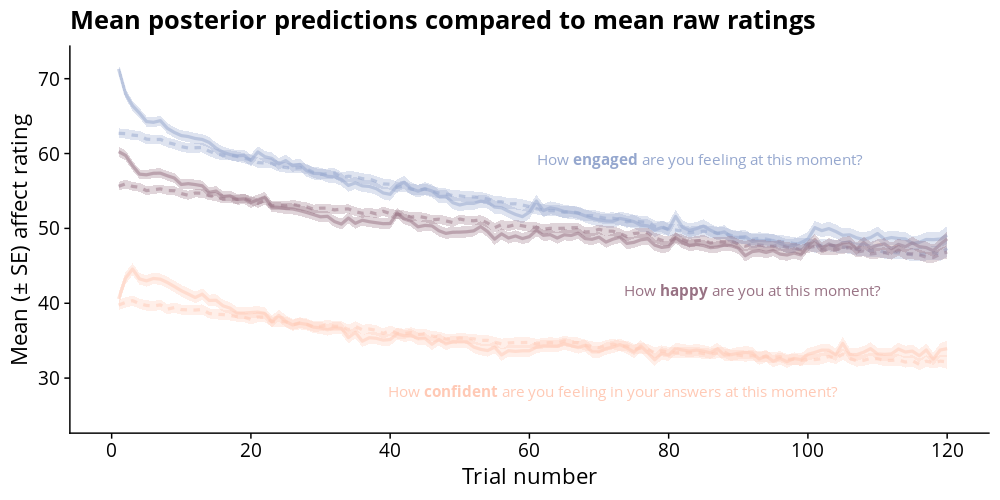

In [21]:
%%R -w 10 -h 5 --units in -r 100
# fits <- readRDS("outputs/cmdstan/affect_2a/fit_dfs_all.RDS")

library(ggtext)
library(patchwork)

happ_label <- 
  "<p style='font-size:11pt; color:#987284'>How <strong>happy</strong> are you at this moment?</p>"
conf_label <- 
  "<p style='font-size:11pt; color:#ffc9b5'>How <strong>confident</strong> are you feeling in your answers at this moment?</p>"
bored_label <- 
  "<p style='font-size:11pt; color:#95a7ce'>How <strong>engaged</strong> are you feeling at this moment?</p>"

expl <- 
  "<p style='font-size:10pt; line-height:1.2; color:black'><strong>Dashed</strong> lines denote predictions sampled <br>from the approximate posterior.</p>"

ppc_plt <-
    pstpipeline::plot_affect(
        list(fits$happy, fits$confident, fits$engaged), 
        plt_type = "grouped", pal = pal_contr, font = "Open Sans", font_size = 16
    ) +
    ggplot2::annotate("richtext", label = conf_label, y = 28, x = 72,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = happ_label, y = 41.5, x = 92,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = bored_label, y = 59, x = 84.5,
                      label.color = NA, family = "Open Sans") +
    ggplot2::ggtitle("Mean posterior predictions compared to mean raw ratings")
    
ppc_plt

We see here that, except for the very start of the task, the model is able to capture the overall trends in affect ratings across all three questions in both groups fairly well, including the small spikes at the start of each block (every twenty trials here, as this is the trial number per question).

### Posterior predictions for individuals with median $R^2$

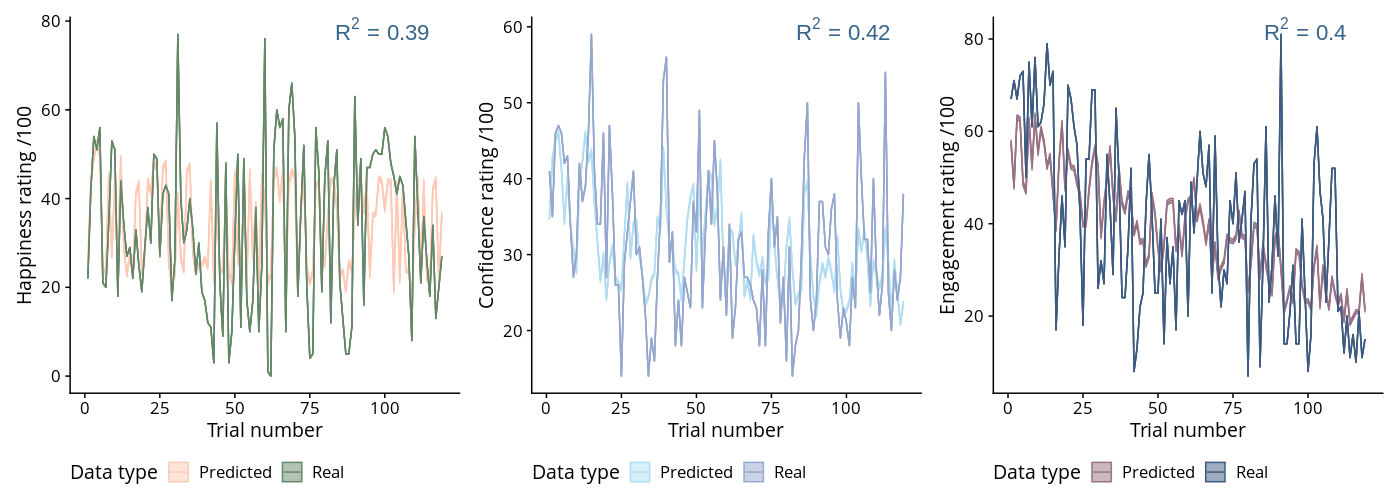

In [22]:
%%R -w 14 -h 5 --units in -r 100
library(patchwork)
med_plts <- pstpipeline::plot_affect(
    fits, plt_type = "individual", pal = pal, font = "Open Sans", 
    font_size = 14, legend_pos = "bottom", r2_coords = c(0.8, 0.97)
)
med_plts$happy + med_plts$confident + med_plts$engaged

### Get parameter values and plot weights

In [23]:
%%R
summary_df_4wt <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_summary.RDS")
raw_df_4wt <- readRDS("outputs/cmdstan/affect_2a/all/model_fits/model_comp/m4/fit_pst_training_2a_vb_raw_df.RDS")

pars <- pstpipeline::make_par_df(raw_df_4wt, summary_df_4wt)

pars_all <- pars |>
    dplyr::group_by(parameter, adj, distanced) |> 
    dplyr::summarise(
        n = dplyr::n(), 
        median = median(posterior_mean, na.rm = TRUE), 
        mean = mean(posterior_mean, na.rm = TRUE),
        sd = sd(posterior_mean),
        min = min(posterior_mean, na.rm = TRUE),
        max = max(posterior_mean, na.rm = TRUE),
        .groups = "keep"
    )
print(pars_all, n = 36)

# A tibble: 36 × 9
# Groups:   parameter, adj, distanced [36]
   parameter adj       distanced     n  median   mean     sd        min   max
   <chr>     <chr>     <lgl>     <int>   <dbl>  <dbl>  <dbl>      <dbl> <dbl>
 1 alpha_neg <NA>      FALSE       476  0.134   0.177 0.166    0.000173 0.863
 2 alpha_neg <NA>      TRUE        459  0.137   0.174 0.169    0.000212 0.828
 3 alpha_pos <NA>      FALSE       476  0.154   0.171 0.104    0.0135   0.700
 4 alpha_pos <NA>      TRUE        459  0.152   0.172 0.103    0.0108   0.757
 5 beta      <NA>      FALSE       476  1.54    1.84  1.49     0.0473   8.31 
 6 beta      <NA>      TRUE        459  1.81    2.11  1.66     0.0459   8.41 
 7 gamma     confident FALSE       476  0.551   0.585 0.165    0.0474   0.970
 8 gamma     confident TRUE        459  0.562   0.582 0.160    0.116    0.973
 9 gamma     engaged   FALSE       476  0.507   0.566 0.176    0.0772   0.984
10 gamma     engaged   TRUE        459  0.506   0.554 0.162    0.166    0.981
11

In [24]:
%%R
par_diffs <- summary_df_4wt |> dplyr::filter(grepl("_diff", variable))
print(par_diffs, n = 15)

# A tibble: 15 × 7
   variable         mean  median      sd     mad      q5     q95
   <chr>           <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1 w0_diff[1]     1.01    1.01   0.00206 0.00202  1.00    1.01  
 2 w0_diff[2]    -0.402  -0.402  0.00210 0.00207 -0.405  -0.398 
 3 w0_diff[3]    -1.41   -1.41   0.00185 0.00192 -1.41   -1.40  
 4 w1_o_diff[1]   0.304   0.304  0.00428 0.00433  0.297   0.311 
 5 w1_o_diff[2]   1.20    1.20   0.00302 0.00279  1.19    1.20  
 6 w1_o_diff[3]   0.894   0.895  0.00415 0.00432  0.888   0.901 
 7 w2_diff[1]    -0.0143 -0.0144 0.00149 0.00146 -0.0167 -0.0118
 8 w2_diff[2]     0.0730  0.0731 0.00153 0.00153  0.0705  0.0756
 9 w2_diff[3]     0.0874  0.0874 0.00148 0.00144  0.0848  0.0897
10 w3_diff[1]    -0.0629 -0.0630 0.00134 0.00131 -0.0651 -0.0606
11 w3_diff[2]     0.0239  0.0239 0.00108 0.00108  0.0221  0.0257
12 w3_diff[3]     0.0868  0.0869 0.00139 0.00137  0.0845  0.0890
13 gamma_diff[1] -0.156  -0.156  0.00176 0.00169 -0.159  -0.153 
14 gam

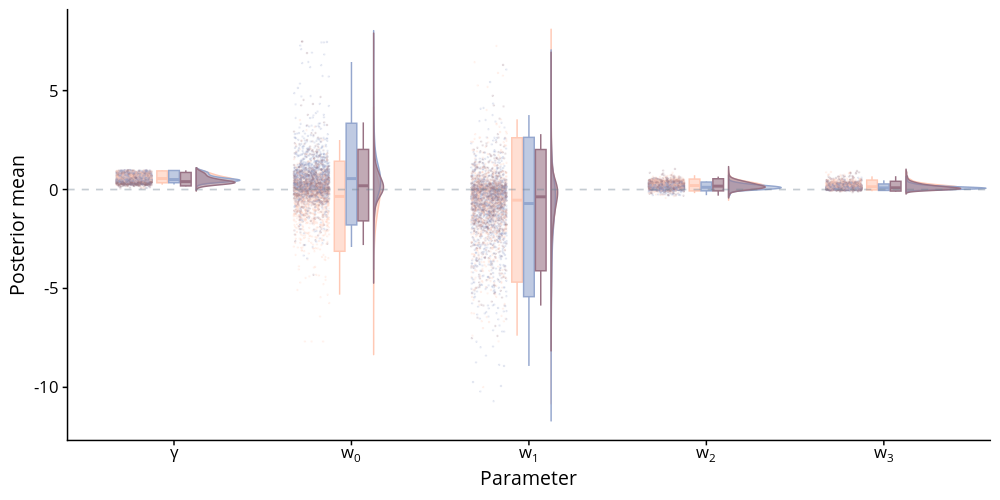

In [25]:
%%R -w 10 -h 5 --units in -r 100

wt_plt <- pstpipeline::plot_affect(
    pars, plt_type = "weights", pal = pal_contr, font = "Open Sans", 
    font_size = 14, legend_pos = "none"
)
wt_plt

Though we can see quite clearly the trends across both groups in baseline ratings ($w_0$), with engagement having the highest baseline rating, and confidence the lowest, it seems there are limited obvious between-group differences (explored further below).

## Parameter recovery

In all cases, data is simulated directly from fitted parameter values, though using a newly randomised set of trials. This is becuase to an extent it is clear the parameters are closely related - simulating a random set of weights and $Q$-learning parameters from approximate distributions resulted in dropped evaluations and failures to fit. This is partly because, by definition, ADVI aims to find an approximate posterior distribution which is multivariate Gaussian in the unconstrained variable space. As such, recovered parameters will be susceptible to biases and intercorrelations found in the original parameter estimates.

### Original model

In [26]:
%%R
# dir.create(file.path("outputs/cmdstan/affect_2a/simulated_data"))
affect_3wt_sim <- pstpipeline::simulate_QL(
    sample_size = 100,
    affect = TRUE,
    time_pars = "none",
    alpha_pos_dens = c(shape1 = 1.5, shape2 = 3),
    alpha_neg_dens = c(shape1 = 1.5, shape2 = 3),
    beta_dens = c(shape1 = 3, shape2 = 4),
    w0_dens = c(mean = 0, sd = 0.5),
    w2_dens = c(mean = 0.2, sd = 0.1),
    w3_dens = c(mean = 0.2, sd = 0.1),
    gamma_dens = c(shape1 = 2, shape2 = 2)
)
saveRDS(affect_3wt_sim, "outputs/cmdstan/affect_2a/simulated_data/affect_3wt_sim.RDS")

  |==============================================================================================================| 100%

In [27]:
%%R
vb_affect_3wt_sim <- pstpipeline::fit_learning_model(
    affect_3wt_sim$sim, model = "2a", exp_part = "training", par_recovery = TRUE, affect = TRUE, 
    affect_sfx = "3wt", vb = TRUE, ppc = TRUE, model_checks = FALSE, iter = 15000, 
    tol_rel_obj = 0.005, outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_2a/simulated_data/3wt"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.427116 seconds 
1000 transitions using 10 leapfrog steps per transition would take 4271.16 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100    -12768908.392             1.000            1.000 
   200     -1064542.277             5.997           10.995 
   300       -51445.1

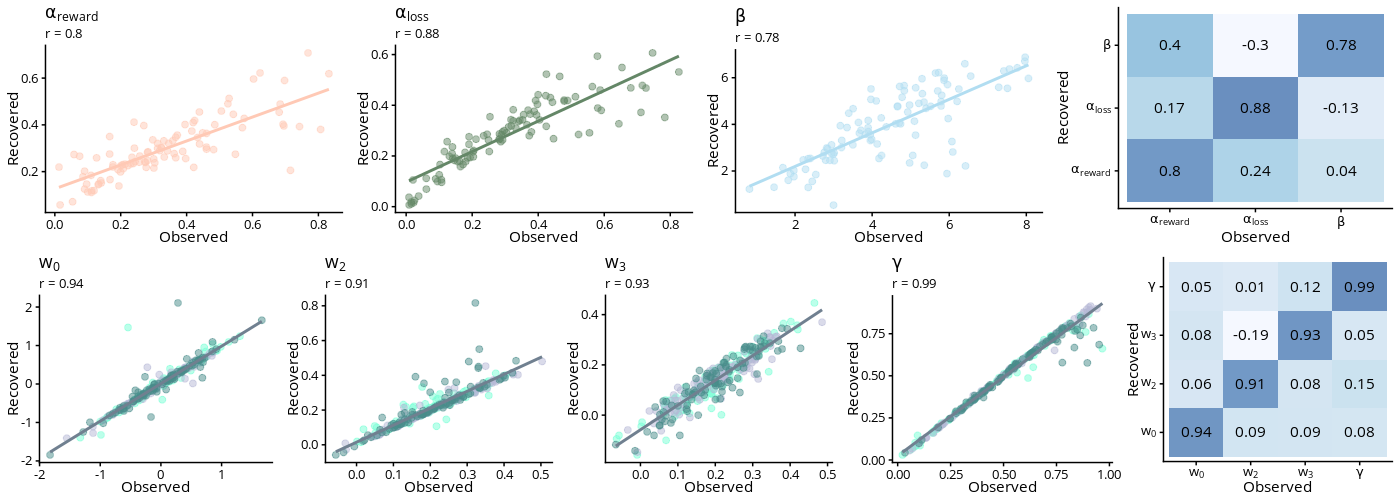

In [28]:
%%R -w 14 -h 5 --units in -r 100
recovery_plots <- list()

affect_3wt_sim <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/affect_3wt_sim.RDS"
)
affect_3wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/3wt/fit_pst_training_2a_vb_summary.RDS"
)

recovery_plots$affect_3wt <- pstpipeline::plot_recovery(
    affect_3wt_sim$pars, affect_3wt_sim_fitted, affect = TRUE, 
    alpha_par_nms = c("reward", "loss"), pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_3wt

### 'Passage-of-time' model

In [29]:
%%R
affect_4wt_sim <- pstpipeline::simulate_QL(
    sample_size = 100,
    affect = TRUE,
    time_pars = "overall",
    alpha_pos_dens = c(shape1 = 1.5, shape2 = 3),
    alpha_neg_dens = c(shape1 = 1.5, shape2 = 3),
    beta_dens = c(shape1 = 3, shape2 = 4),
    w0_dens = c(mean = 0, sd = 0.5),
    w1_o_dens = c(mean = -0.5, sd = 1),
    w2_dens = c(mean = 0.2, sd = 0.1),
    w3_dens = c(mean = 0.2, sd = 0.1),
    gamma_dens = c(shape1 = 2, shape2 = 2)
)
saveRDS(affect_4wt_sim, "outputs/cmdstan/affect_2a/simulated_data/affect_4wt_sim.RDS")

  |==============================================================================================================| 100%

In [30]:
%%R
vb_affect_4wt_sim <- pstpipeline::fit_learning_model(
    affect_4wt_sim$sim, model = "2a", exp_part = "training", par_recovery = TRUE, affect = TRUE, 
    affect_sfx = "4wt_time", vb = TRUE, ppc = TRUE, model_checks = FALSE, iter = 15000, 
    tol_rel_obj = 0.005, outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_2a/simulated_data/4wt"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.350982 seconds 
1000 transitions using 10 leapfrog steps per transition would take 3509.82 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -147885.855             1.000            1.000 
   200       -64821.781             1.141            1.281 
   300       -32844.5

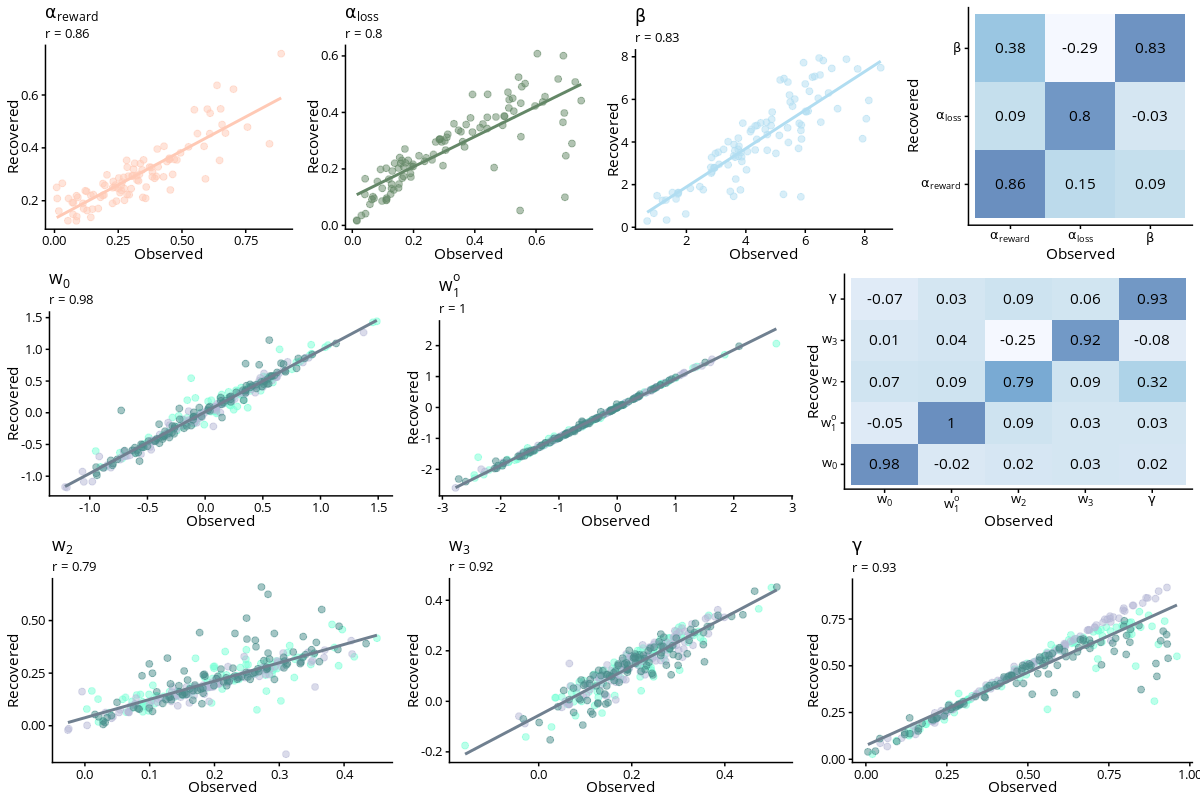

In [31]:
%%R -w 12 -h 8 --units in -r 100
affect_4wt_sim <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/affect_4wt_sim.RDS"
)
affect_4wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_2a/simulated_data/4wt/fit_pst_training_2a_vb_summary.RDS"
)

recovery_plots$affect_4wt_time <- pstpipeline::plot_recovery(
    affect_4wt_sim$pars, affect_4wt_sim_fitted, affect = TRUE, 
    alpha_par_nms = c("reward", "loss"), pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_4wt_time

In all models, it appears that the weights, and to a lesser extent the decay factor $\gamma$, are well-recovered by all three models investigated here, with relatively low confusability (except, perhaps unsurprisingly, $w_2$ and $w_3$). However, the $Q$-learning parameters were not as well-recovered, especially the learning rates, which appeared highly intercorrelated.

## Associations between model parameters and transdiagnostic mental health

First, we take a look at the raw correlations between baseline affect ($w_0$) and each of the three transdiagnostic mental health dimensions of interest - anxiety/depression, compulsive behaviour, and social withdrawal (see the "data_cleaning_factor_derivation" notebook for more information on these).

In [32]:
%%R
factor_scores <- read.csv("/group/cemhp/E3_Data/online_decision_making/package_outputs_dec_2021/outputs/factor_prediction/all_935_predicted_factor_scores.csv")[-1]

cor_test <- function(df, adj, factor) {
  tst <- cor.test(df[df$adj == adj,]$posterior_mean, df[df$adj == adj,][[factor]])
  tibble::tibble(
    "factor" = factor,
    "adj" = adj,
    "est" = tst$estimate[1], 
    "conf_int" = paste0(
      "(", round(tst$conf.int[1], 3), ", ",  round(tst$conf.int[2], 3), ")"
    ), 
    "p_value" = ifelse(
      tst$p.value[1] < 0.0001, "<0.0001", 
      format(round(tst$p.value[1], digits = 4), nsmall = 4, scientific = FALSE))
    )
}

w0_factors_df <- dplyr::filter(
  dplyr::left_join(pars, factor_scores, by = "subjID"), parameter == "w0"
)

dplyr::bind_rows(
  cor_test(w0_factors_df, "happy", "AD"),
  cor_test(w0_factors_df, "happy", "Compul"),
  cor_test(w0_factors_df, "happy", "SW"),
  cor_test(w0_factors_df, "confident", "AD"),
  cor_test(w0_factors_df, "confident", "Compul"),
  cor_test(w0_factors_df, "confident", "SW"),
  cor_test(w0_factors_df, "engaged", "AD"),
  cor_test(w0_factors_df, "engaged", "Compul"),
  cor_test(w0_factors_df, "engaged", "SW"),
)

# A tibble: 9 × 5
  factor adj           est conf_int         p_value
  <chr>  <chr>       <dbl> <chr>            <chr>  
1 AD     happy     -0.242  (-0.302, -0.181) <0.0001
2 Compul happy     -0.113  (-0.175, -0.049) 0.0006 
3 SW     happy     -0.123  (-0.186, -0.059) 0.0002 
4 AD     confident -0.177  (-0.238, -0.114) <0.0001
5 Compul confident -0.0288 (-0.093, 0.035)  0.3797 
6 SW     confident -0.125  (-0.188, -0.062) 0.0001 
7 AD     engaged   -0.152  (-0.214, -0.089) <0.0001
8 Compul engaged   -0.126  (-0.189, -0.062) 0.0001 
9 SW     engaged   -0.0478 (-0.112, 0.016)  0.1442 


Notably, there appears to be strong evidence of a moderate negative correlation between high anxiety/depression scores, and baseline happiness, confidence, and engagement. In addition there is a weaker evidence of negative associations between compulsive behaviour scores and baseline happinesss and engagement, as well as social withdrawal with happiness and confidence.

To investigate this further, we use Bayesian generalised linear models (GLMs), adjusted for age, sex, digit span, and distancing group. The response distribution was assumed to be Gaussian for all weight parameters plus inverse temperatures ($\beta$), and Gamma for learning rates ($\alpha$) and the decay factor ($\gamma$). We primarily focus on the affect-related parameters here given these potential issues with the $Q$-learning parameters.

### Association between anxiety/depression scores and affect model parameters

In [33]:
%%R
AD_affect <- list()

AD_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.3 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.3 seconds.
Chain 3 finished in 7.3 seconds.
Chain 4 finished in 7.4 seconds.
Chain 2 finished in 7.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 7.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.3 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 1 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 2 finished in 7.2 seconds.
Chain 3 finished in 7.3 seconds.
Chain 4 finished in 7.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 7.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.
Chain 1 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.1 seconds.
Chain 2 finished in 7.2 seconds.
Chain 3 finished in 7.2 seconds.
Chain 4 finished in 7.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.2 seconds.
Total execution time: 7.4 seconds.


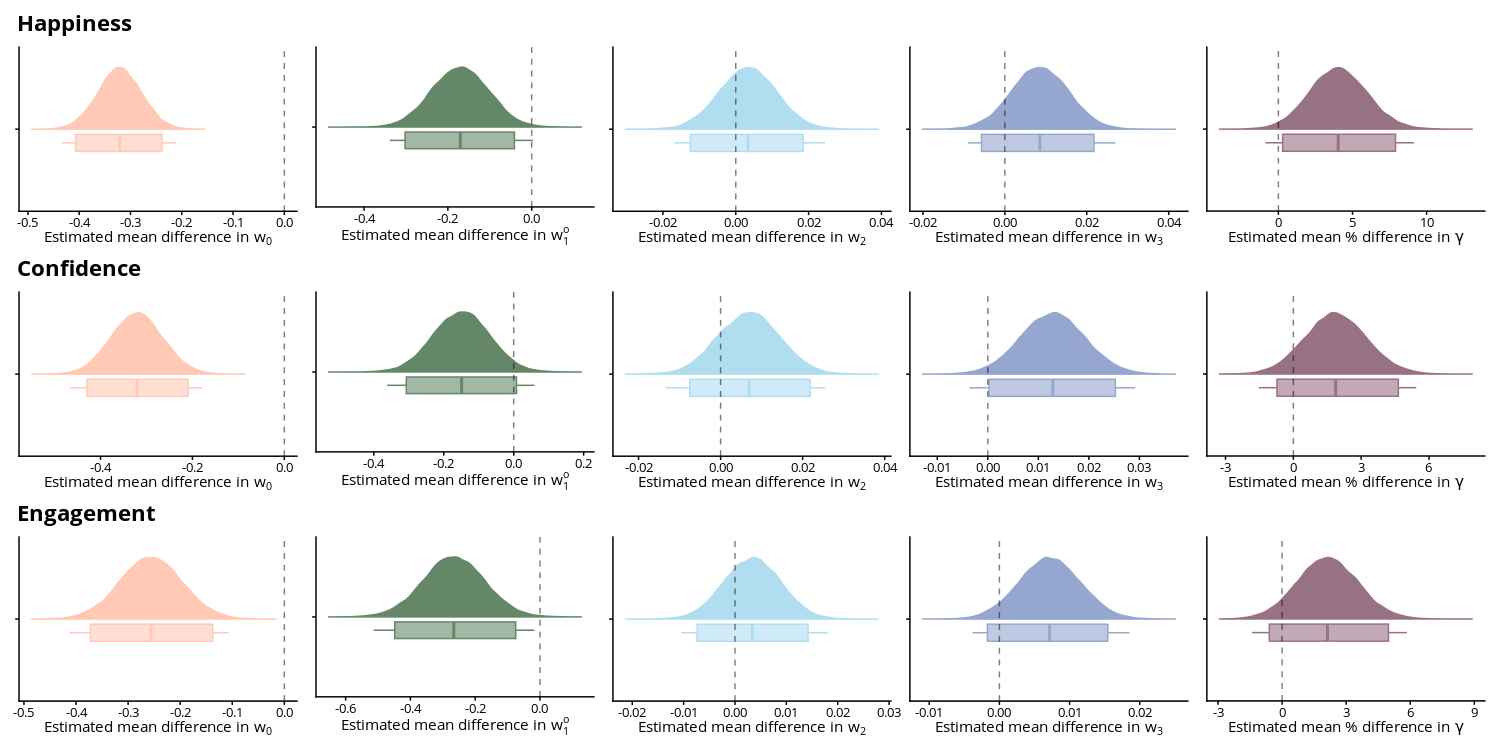

In [34]:
%%R -w 15 -h 7.5 --units in -r 100
library(patchwork)

AD_plt_happy <- pstpipeline::plot_glm(
  AD_affect$happy, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_plt_conf <- pstpipeline::plot_glm(
  AD_affect$confident, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_plt_bored <- pstpipeline::plot_glm(
  AD_affect$engaged, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_plt_happy / AD_plt_conf / AD_plt_bored

Here we again see clear evidence that higher anxiety/depression scores are associated with lower baseline affect ratings, after controlling for age, sex, digit span, and distancing group. However, there is little evidence of an association between anxiety/depression scores and any other model parameter, except for a weak association between higher scores and higher decay factor on $w_2$ and $w_3$ for engagement. This suggests that those with higher anxiety/depression scores incorporate slightly more trials in their calculation of the delay discounted effects of expected value and prediction error. In addition, on average, those with lower anxiety/depression scores appear to decay more in happiness and engagement (i.e., higher $w^o_1$), an observation previously noted by [Jangraw *et al.,* 2022](https://psyarxiv.com/bwv58) in their paper on "passage-of-time" dysphoria, though in our case the evidence for this is very weak.

### Association between compulsive behaviour factor scores and model parameters

In [35]:
%%R
CB_affect <- list()

CB_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

CB_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

CB_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 1 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 4 finished in 7.3 seconds.
Chain 2 finished in 7.4 seconds.
Chain 3 finished in 8.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.3 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.8 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 7.0 seconds.
Chain 4 finished in 7.0 seconds.
Chain 2 finished in 7.7 seconds.
Chain 1 finished in 7.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 4 finished in 1.3 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 6.9 seconds.
Chain 1 finished in 7.4 seconds.
Chain 4 finished in 7.5 seconds.
Chain 2 finished in 7.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.1 seconds.


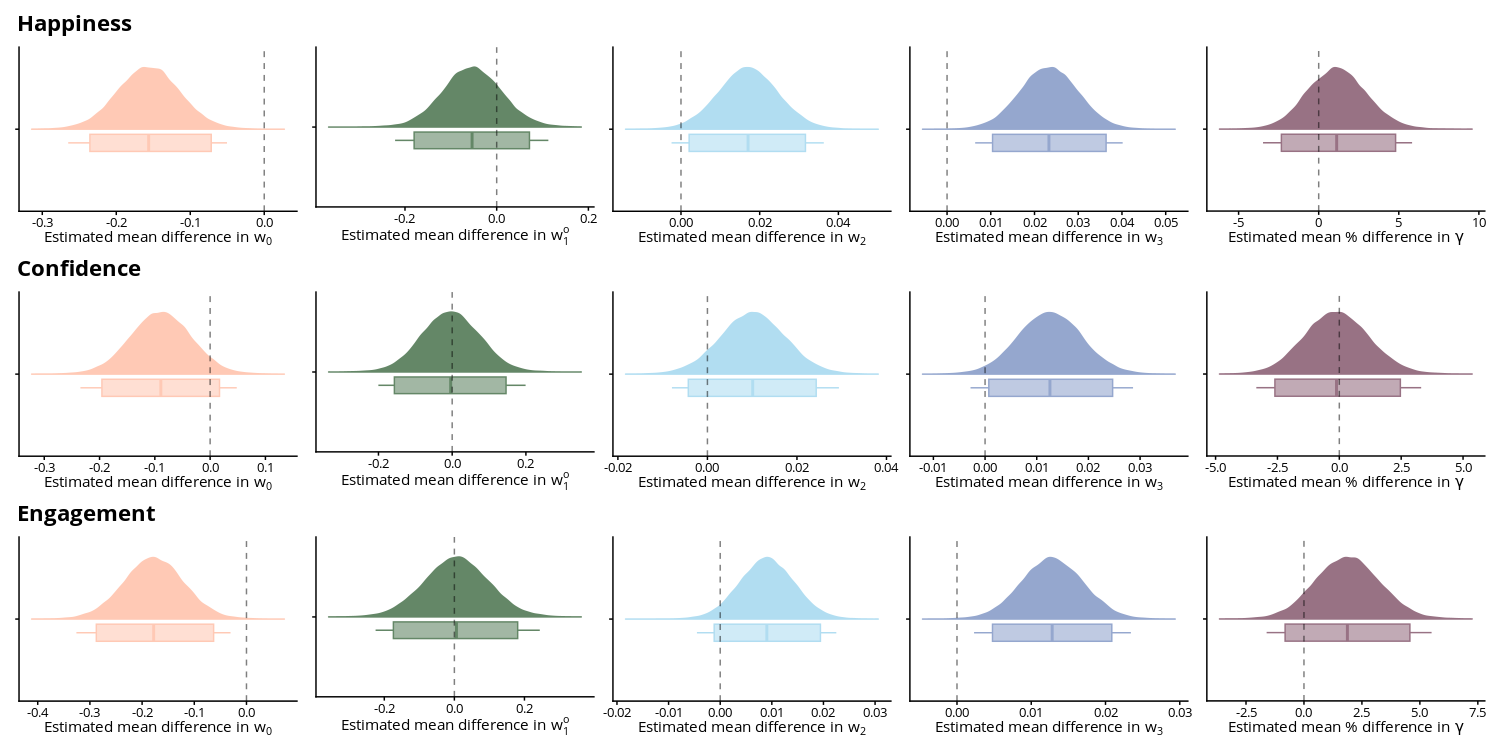

In [36]:
%%R -w 15 -h 7.5 --units in -r 100

CB_plt_happy <- pstpipeline::plot_glm(
  CB_affect$happy, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
CB_plt_conf <- pstpipeline::plot_glm(
  CB_affect$confident, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
CB_plt_bored <- pstpipeline::plot_glm(
  CB_affect$engaged, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

CB_plt_happy / CB_plt_conf / CB_plt_bored

Interestingly, it appears that higher compusive behaviour factor scores are not associated with any differences in confidence model parameters. However, there is evidence that, like anxiety/depression, higher compulsive behaviour factor scores are asssociated with lower baseline happiness and engagement ($w_0$). In addition, those with higher compulsive behaviour scores have higher values for $w_2$ and $w_3$, or weights on Q-learning model expected values and prediction errors. What this may ultimately translate to is increased fluctuations in score following wins and losses.

### Association between social withdrawal factor scores and model parameters

In [37]:
%%R
SW_affect <- list()

SW_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

SW_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

SW_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.3 seconds.
Chain 2 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.2 seconds.
Chain 2 finished in 7.5 seconds.
Chain 3 finished in 7.5 seconds.
Chain 4 finished in 7.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.5 seconds.
Total execution time: 8.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.4 seconds.
Chain 4 finished in 7.3 seconds.
Chain 2 finished in 7.5 seconds.
Chain 3 finished in 8.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.6 seconds.
Total execution time: 8.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 7.1 seconds.
Chain 3 finished in 7.4 seconds.
Chain 4 finished in 7.5 seconds.
Chain 1 finished in 7.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.0 seconds.


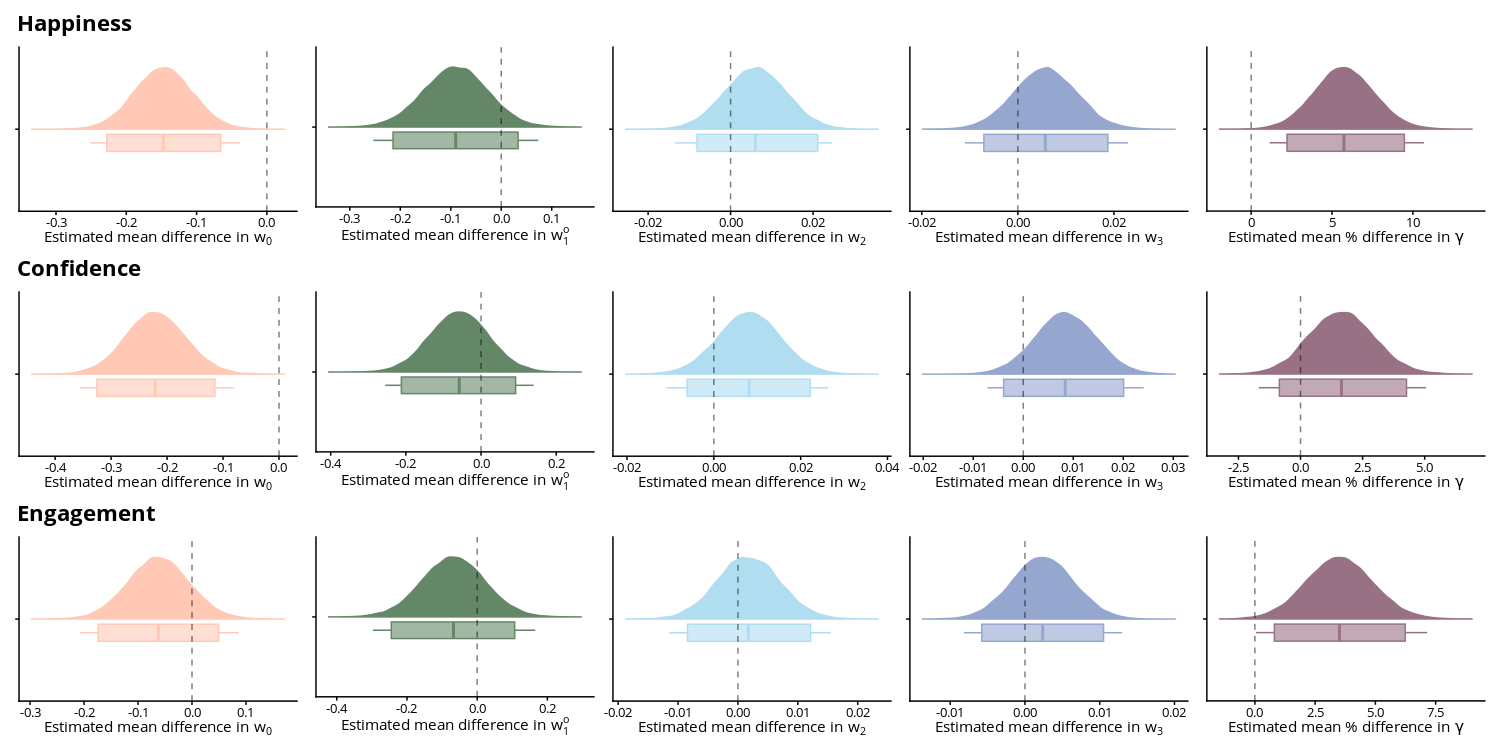

In [38]:
%%R -w 15 -h 7.5 --units in -r 100

SW_plt_happy <- pstpipeline::plot_glm(
  SW_affect$happy, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
SW_plt_conf <- pstpipeline::plot_glm(
  SW_affect$confident, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
SW_plt_bored <- pstpipeline::plot_glm(
  SW_affect$engaged, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

SW_plt_happy / SW_plt_conf / SW_plt_bored

Lastly, for social withdrawal factor scores, higher scores are associated again with lower baseline happiness, as well as lower baseline confidence, but not lower baseline engagement. There is limited evidence of any association with any other model parameters, however.

In [39]:
%%R
transdiag_aff_mods <- list()
transdiag_aff_mods$AD <- AD_affect
transdiag_aff_mods$CB <- CB_affect
transdiag_aff_mods$SW <- SW_affect

dir.create("outputs/cmdstan/affect_2a/outcome_glms")
saveRDS(transdiag_aff_mods, "outputs/cmdstan/affect_2a/outcome_glms/transdiag_affect_models.RDS")

## Associations between model parameters and cognitive distancing

First, we take a look to see whether we can replicate our previous findings - that cognitive distancing is associated with higher inverse temperatures ($\beta$) and late-stage increases in negative learning rates ($\alpha_{loss}$) during the probabilistic selection task.

In [40]:
%%R
dist_QL_affect <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.3 seconds.
Chain 2 finished in 7.3 seconds.
Chain 4 finished in 7.3 seconds.
Chain 3 finished in 8.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.6 seconds.
Total execution time: 8.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.7 seconds.
Chain 4 finished in 6.6 seconds.
Chain 3 finished in 7.2 seconds.
Chain 1 finished in 8.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 8.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.7 seconds.


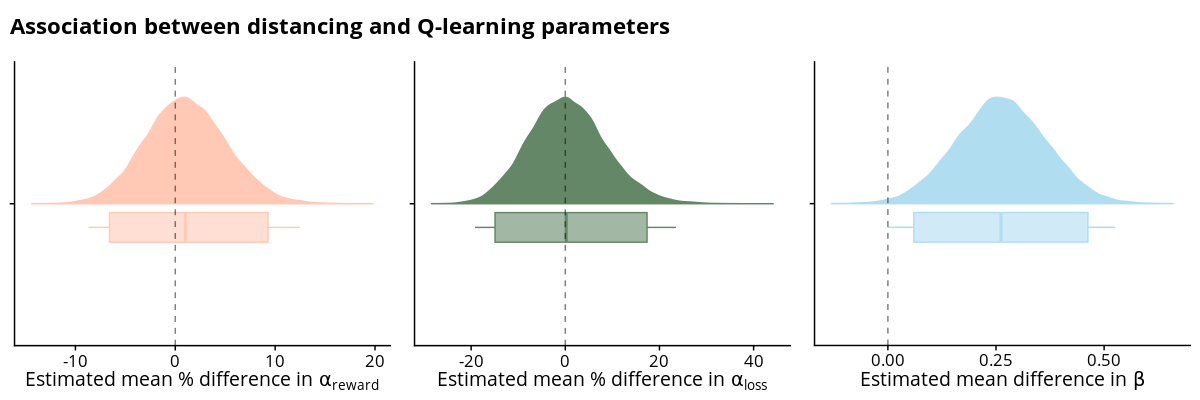

In [41]:
%%R -w 12 -h 4 --units in -r 100

dist_plt_QL <- pstpipeline::plot_glm(
  dist_QL_affect, plot_var = "distanced", alpha_par_nms = c("reward", "loss"), 
  font = "Open Sans", font_size = 14, pal = pal, 
  ovrll_title = "Association between distancing and Q-learning parameters"
)
dist_plt_QL

Interestingly, we replicate our finding that the distanced group appear to have higher inverse temperatures by the end of training. However, differences in learning rates are not seen in this model - this is perhaps unsurprising given the poor recovery of these parameters observed previously.

In [42]:
%%R
dist_models <- list()

dist_models$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  iter_warmup = 2000, iter_sampling = 10000
)

dist_models$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  iter_warmup = 2000, iter_sampling = 10000
)

dist_models$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.1 seconds.
Chain 4 finished in 7.1 seconds.
Chain 2 finished in 7.5 seconds.
Chain 3 finished in 7.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 7.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.3 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 4 finished in 1.3 seconds.
Chain 3 finished in 1.5 seconds.
Chain 2 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.5 seconds.
Chain 1 finished in 1.7 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.3 seconds.
Chain 3 finished in 7.4 seconds.
Chain 4 finished in 7.3 seconds.
Chain 2 finished in 7.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.3 seconds.
Total execution time: 1.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.5 seconds.
Chain 4 finished in 1.3 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.2 seconds.
Chain 2 finished in 7.1 seconds.
Chain 3 finished in 7.4 seconds.
Chain 4 finished in 7.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.1 seconds.


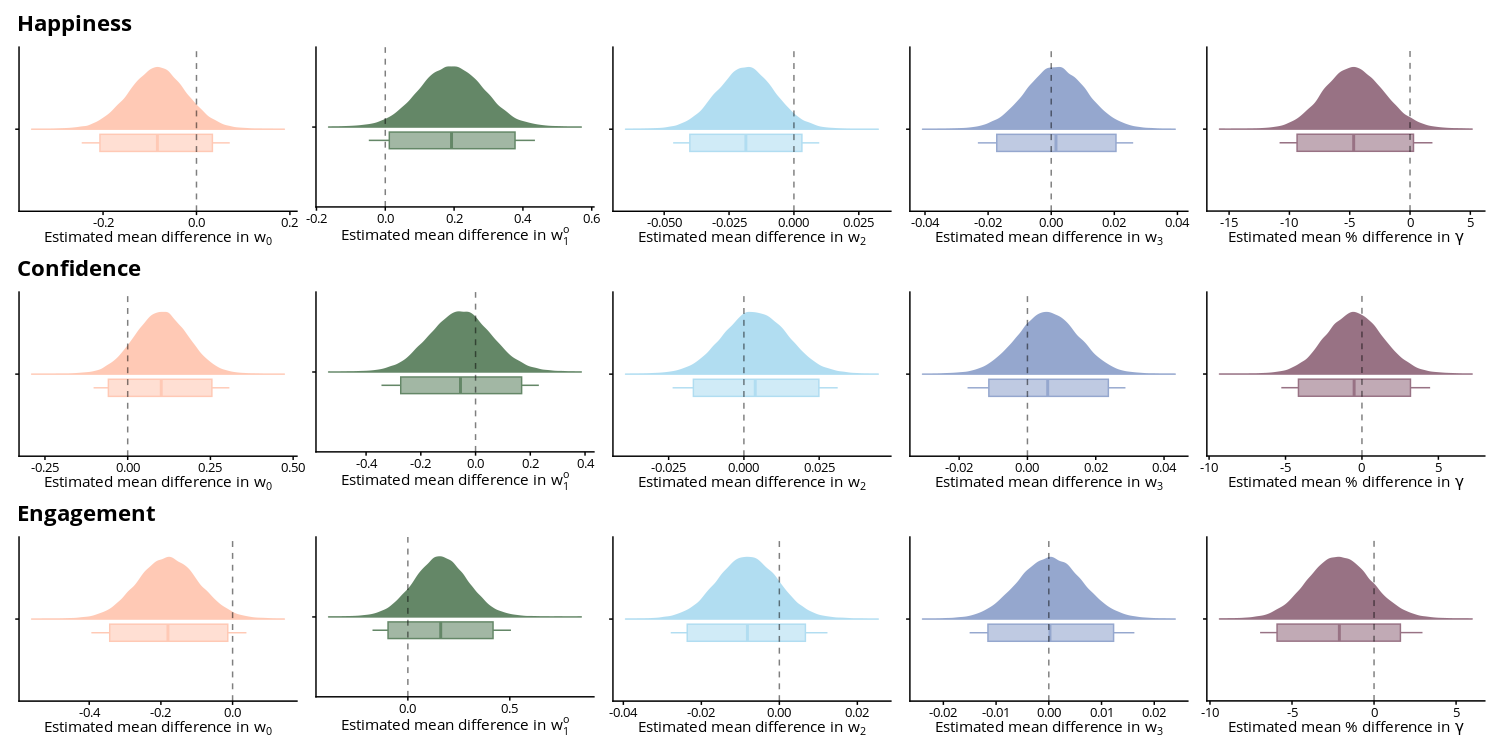

In [43]:
%%R -w 15 -h 7.5 --units in -r 100

dist_plt_happy <- pstpipeline::plot_glm(
  dist_models$happy, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
dist_plt_conf <- pstpipeline::plot_glm(
  dist_models$confident, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
dist_plt_bored <- pstpipeline::plot_glm(
  dist_models$engaged, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

dist_plt_happy / dist_plt_conf / dist_plt_bored

These results indicate that participants in the distancing group differed only with respect to their decay in affect throughout the task, which interestly differed across the three adjectives. Distanced individuals decayed less across the task in terms of happiness (higher $w^o_1$), remained *more* engaged throughout the blocks (higher $w^b_1$), but became *less* confident thoughout those same blocks (lower $w^b_1$). Notably, these results also replicate those from simple analyses found in our [earlier preprint](https://psyarxiv.com/jmnek), where we found in multilevel models with a random intercept for participant ID that distanced participants decreased less in happiness and engagement, but not confidence, over the course of the task. It is perhaps also notable that group differences in decay of happiness and engagement were comparable - this suggests, again as noted by [previous work](https://psyarxiv.com/bwv58), that decay of happiness ratings may be related to boredom.

In [44]:
%%R
saveRDS(dist_models, "outputs/cmdstan/affect_2a/outcome_glms/distancing_affect_models.RDS")

## Exploratory analysis 1: Do associations between anxiety/depression scores and model parameters differ by 'treatment' group?

Though we did have a primary "treatment" group - participants who engaged in cognitive distancing - we also asked individuals about medication usage, and a fairly large number reported being on an antidepressant (n=130 of the 935 non-excluded individuals (13.9\%); 69 distanced). This allows us to compare the effect of a psychological treatment (cognitive distancing) and a pharmacological treatment (antidepressants).

### Cognitive distancing

In [45]:
%%R
AD_dist_int <- list()

AD_dist_int$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  interaction = "distanced", 
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_dist_int$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  interaction = "distanced",
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_dist_int$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  interaction = "distanced", 
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 3 finished in 2.7 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 2.7 seconds.
Chain 4 finished in 2.5 seconds.
Chain 3 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 4 finished in 2.4 seconds.
Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.4 seconds.
Chain 1 finished in 2.8 seconds.
Chain 3 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 17.5 seconds.
Chain 2 finished in 19.1 seconds.
Chain 1 finished in 20.5 seconds.
Chain 4 finished in 20.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 19.3 seconds.
Total execution time: 20.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.5 seconds.
Chain 2 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 3 finished in 2.6 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 2.3 seconds.
Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 17.5 seconds.
Chain 3 finished in 17.4 seconds.
Chain 1 finished in 18.7 seconds.
Chain 4 finished in 19.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 18.3 seconds.
Total execution time: 20.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.4 seconds.
Chain 3 finished in 2.6 seconds.
Chain 1 finished in 2.8 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.4 seconds.
Chain 1 finished in 2.8 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 17.1 seconds.
Chain 3 finished in 17.7 seconds.
Chain 1 finished in 20.1 seconds.
Chain 4 finished in 20.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 18.8 seconds.
Total execution time: 20.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.5 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.7 seconds.
Chain 4 finished in 2.6 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.5 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 4 finished in 2.5 seconds.
Chain 2 finished in 2.9 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 17.8 seconds.
Chain 3 finished in 18.0 seconds.
Chain 1 finished in 18.9 seconds.
Chain 2 finished in 18.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 18.4 seconds.
Total execution time: 19.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 4 finished in 2.4 seconds.
Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 4 finished in 2.7 seconds.
Chain 3 finished in 3.0 seconds.
Chain 2 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.6 seconds.
Chain 1 finished in 3.0 seconds.
Chain 3 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 2.4 seconds.
Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.6 seconds.
Chain 1 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 15.7 seconds.
Chain 3 finished in 17.0 seconds.
Chain 1 finished in 18.5 seconds.
Chain 2 finished in 19.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 17.8 seconds.
Total execution time: 20.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.4 seconds.
Chain 4 finished in 2.8 seconds.
Chain 1 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.5 seconds.
Chain 3 finished in 2.7 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 2 finished in 2.7 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 17.7 seconds.
Chain 4 finished in 18.1 seconds.
Chain 1 finished in 18.5 seconds.
Chain 2 finished in 19.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 18.4 seconds.
Total execution time: 19.7 seconds.


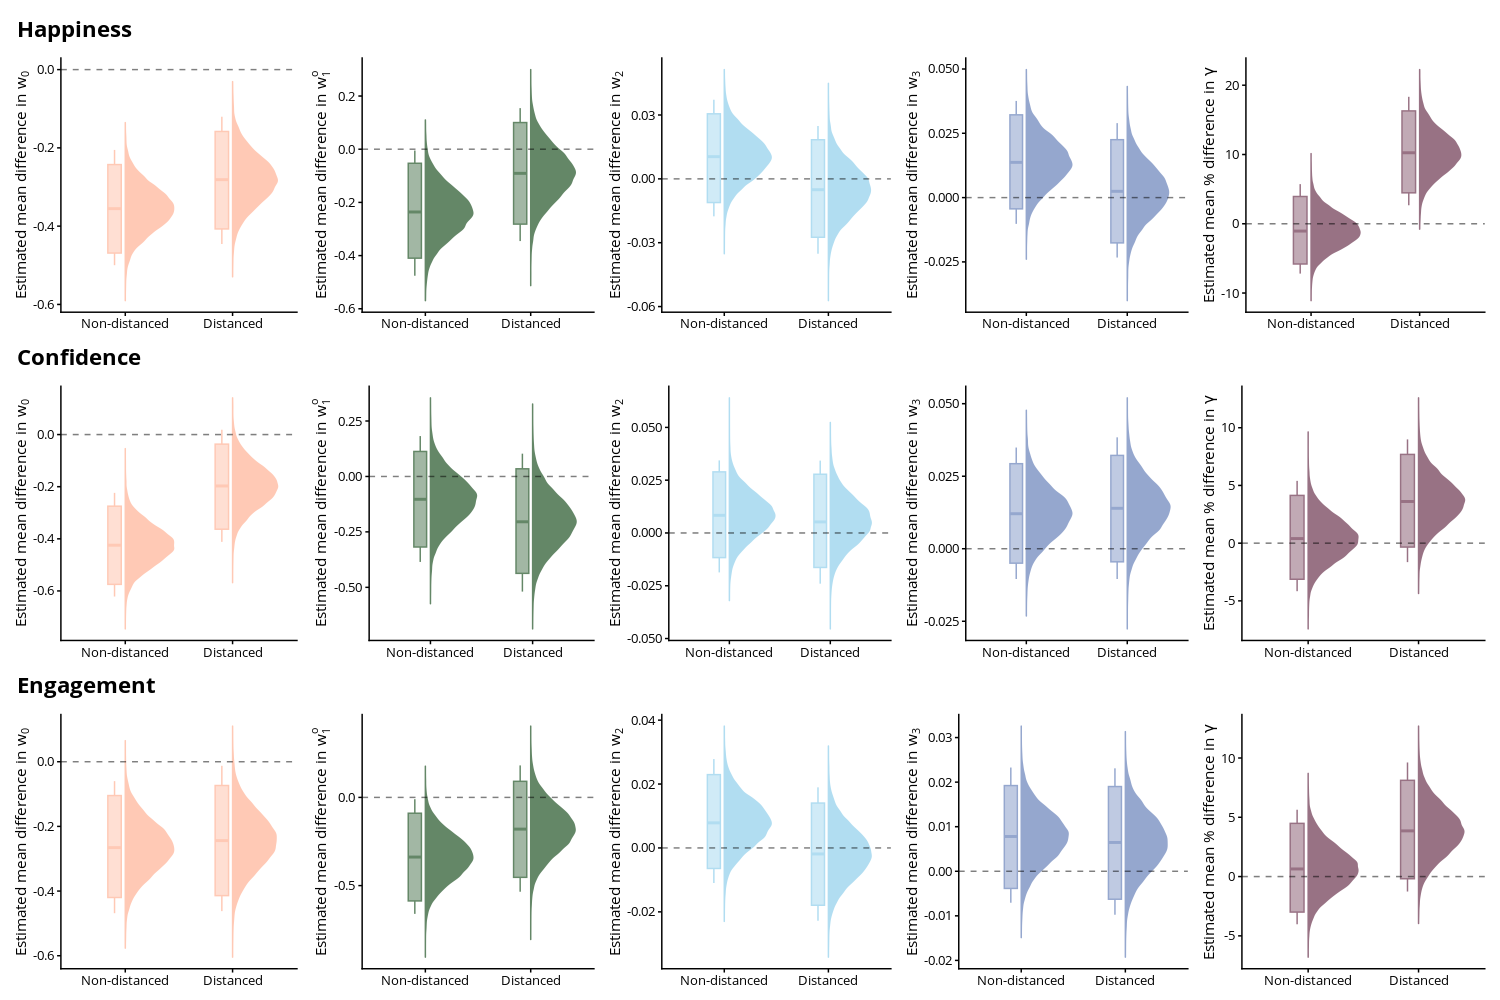

In [46]:
%%R -w 15 -h 10 --units in -r 100

AD_dist_plt_happy <- pstpipeline::plot_glm(
  AD_dist_int$happy, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_dist_plt_conf <- pstpipeline::plot_glm(
  AD_dist_int$confident, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_dist_plt_bored <- pstpipeline::plot_glm(
  AD_dist_int$engaged, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_dist_plt_happy / AD_dist_plt_conf / AD_dist_plt_bored

These results suggest that the association between increases in anxiety/depression scores and lower baseline affect did not appear to differ between distanced and non-distanced individuals. However, interestingly, distanced individuals scoring higher in terms of anxiety/depression tended to integrate information from more trials in their incorporation of expected value and prediction error into their effect, though the evidence for this was strong only for engagement. Very speculatively, one could suggest that distancing specifically helped those with higher anxiety/depression symptoms to integrate information from wins and losses.

### Antidepressant usage

In [47]:
%%R
AD_antidep_int <- list()

AD_antidep_int$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_antidep_int$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_antidep_int$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.0 seconds.
Chain 1 finished in 3.2 seconds.
Chain 3 finished in 3.3 seconds.
Chain 4 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 4.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.0 seconds.
Chain 2 finished in 3.0 seconds.
Chain 4 finished in 2.8 seconds.
Chain 3 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 3 finished in 3.0 seconds.
Chain 4 finished in 2.9 seconds.
Chain 2 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.0 seconds.
Chain 1 finished in 3.2 seconds.
Chain 3 finished in 3.0 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 23.0 seconds.
Chain 4 finished in 23.0 seconds.
Chain 1 finished in 23.8 seconds.
Chain 3 finished in 24.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 23.5 seconds.
Total execution time: 24.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.0 seconds.
Chain 2 finished in 3.1 seconds.
Chain 3 finished in 3.0 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.2 seconds.
Chain 4 finished in 2.9 seconds.
Chain 2 finished in 3.3 seconds.
Chain 3 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 4.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 3.0 seconds.
Chain 3 finished in 2.9 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.9 seconds.
Chain 1 finished in 3.2 seconds.
Chain 4 finished in 2.8 seconds.
Chain 3 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 22.2 seconds.
Chain 1 finished in 22.9 seconds.
Chain 4 finished in 23.0 seconds.
Chain 2 finished in 24.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 23.2 seconds.
Total execution time: 24.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.9 seconds.
Chain 1 finished in 3.2 seconds.
Chain 3 finished in 3.3 seconds.
Chain 4 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 3.0 seconds.
Chain 3 finished in 3.0 seconds.
Chain 4 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 4.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 2.9 seconds.
Chain 3 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.6 seconds.
Chain 1 finished in 3.1 seconds.
Chain 4 finished in 2.8 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 21.7 seconds.
Chain 2 finished in 21.9 seconds.
Chain 3 finished in 22.0 seconds.
Chain 4 finished in 23.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 22.2 seconds.
Total execution time: 23.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 3 finished in 2.6 seconds.
Chain 2 finished in 3.3 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.0 seconds.
Chain 2 finished in 3.1 seconds.
Chain 4 finished in 3.0 seconds.
Chain 3 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 2 finished in 3.1 seconds.
Chain 3 finished in 3.1 seconds.
Chain 4 finished in 3.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 4 finished in 2.9 seconds.
Chain 3 finished in 3.1 seconds.
Chain 2 finished in 3.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 22.5 seconds.
Chain 4 finished in 23.0 seconds.
Chain 3 finished in 23.6 seconds.
Chain 2 finished in 24.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 23.3 seconds.
Total execution time: 24.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.7 seconds.
Chain 1 finished in 2.9 seconds.
Chain 4 finished in 2.9 seconds.
Chain 3 finished in 3.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.0 seconds.
Chain 3 finished in 2.8 seconds.
Chain 2 finished in 3.3 seconds.
Chain 4 finished in 3.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.2 seconds.
Chain 3 finished in 2.9 seconds.
Chain 4 finished in 2.8 seconds.
Chain 2 finished in 3.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 4.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 3.3 seconds.
Chain 3 finished in 3.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 4.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 21.7 seconds.
Chain 1 finished in 22.0 seconds.
Chain 4 finished in 22.9 seconds.
Chain 3 finished in 24.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 22.7 seconds.
Total execution time: 24.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 2.8 seconds.
Chain 1 finished in 3.2 seconds.
Chain 2 finished in 3.1 seconds.
Chain 4 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 4.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.1 seconds.
Chain 2 finished in 3.0 seconds.
Chain 3 finished in 3.4 seconds.
Chain 4 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 3.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 2.6 seconds.
Chain 1 finished in 3.0 seconds.
Chain 2 finished in 2.8 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 3.0 seconds.
Chain 4 finished in 2.8 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 21.4 seconds.
Chain 3 finished in 22.6 seconds.
Chain 4 finished in 22.8 seconds.
Chain 2 finished in 24.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 22.8 seconds.
Total execution time: 24.7 seconds.


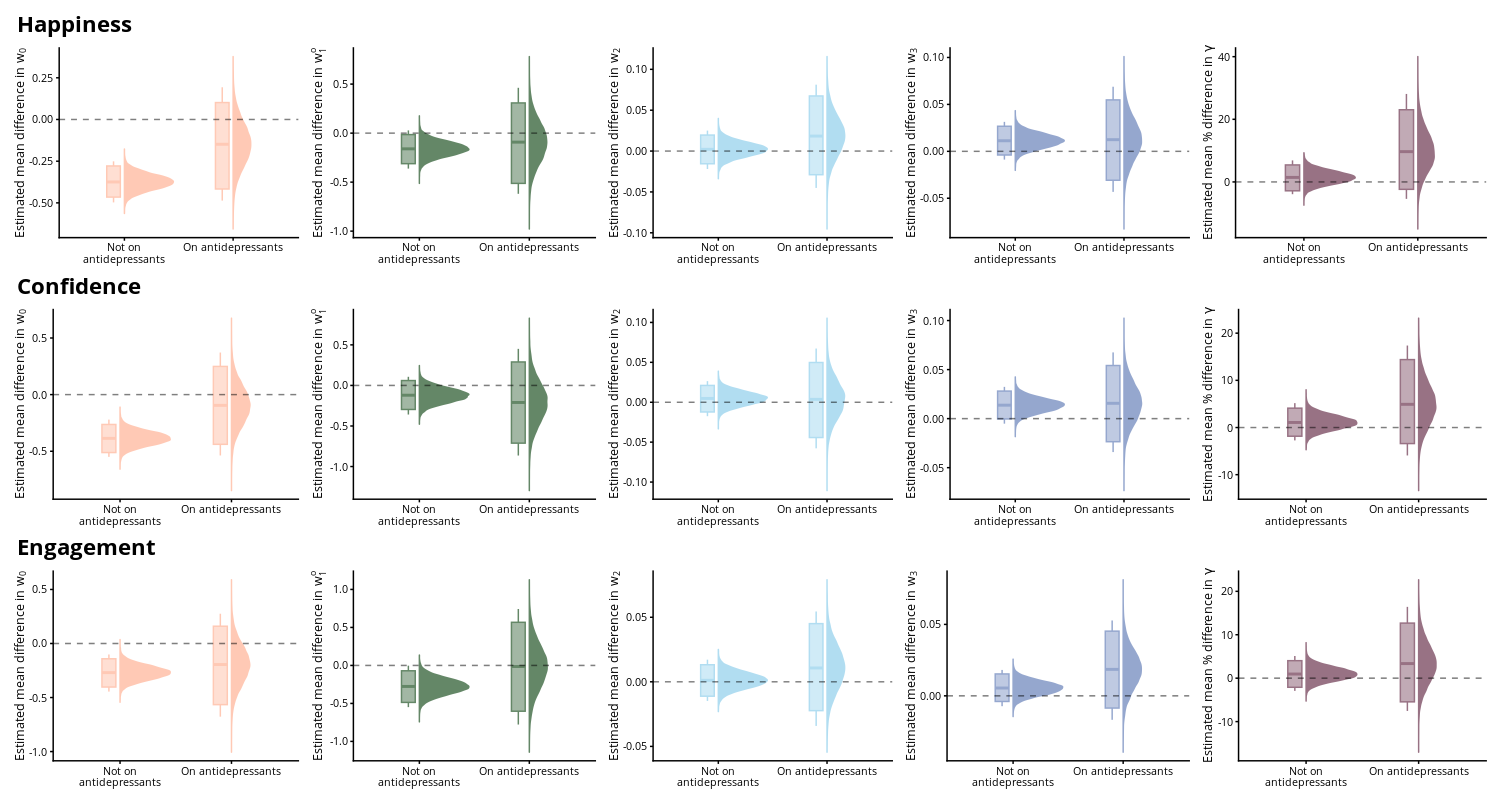

In [48]:
%%R -w 15 -h 8 --units in -r 100

AD_antidep_plt_happy <- pstpipeline::plot_glm(
  AD_antidep_int$happy, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_antidep_plt_conf <- pstpipeline::plot_glm(
  AD_antidep_int$confident, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_antidep_plt_bored <- pstpipeline::plot_glm(
  AD_antidep_int$engaged, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_antidep_plt_happy / AD_antidep_plt_conf / AD_antidep_plt_bored

Interestingly, we find that the negative association between baseline affect and anxiety/depression scores is not seen in those currently taking antidepressant. In addition, we see evidence of a similar effect on the decay factor $\gamma$ to cognitive distancing, whereby increases in anxiety/depression scores are associated with increased $\gamma$ only in those on antidepressants.

In [49]:
%%R
explore_AD_grp <- list()
explore_AD_grp$AD_dist_int <- AD_dist_int
explore_AD_grp$AD_antidep_int <- AD_antidep_int

saveRDS(explore_AD_grp, "outputs/cmdstan/affect_2a/outcome_glms/exploratory_AD_interaction_models.RDS")

## Exploratory analysis 2: Associations between model parameters and self-reported fatigue

One final point of interest is whether self-reported fatigue, which was reported between 0 and 100 at the end of each block in response to the question *"How **fatigued** do you feel compared to the beginning of the block?"*, related to the model parameters. Here we look at two quantities - the mean post-block fatigue score, which should correlate with $w^b_1$, and the per-block change in this post-block fatigue score (i.e., coefficient from regression of fatigue score on trial block), which may perhaps relate more to the overall decay in affect ($w^o_1$).

In [50]:
%%R
all_res_split <- readRDS("data-raw/all_res_split.RDS")

fatigue <- dplyr::bind_rows(
    all_res_split$non_distanced$training, 
    all_res_split$distanced$training
  ) |>
  dplyr::filter(!is.na(fatigue_response)) |>
  dplyr::mutate(fatigue_response = fatigue_response / 10) |>
    # so now unit increase = 10%
  dplyr::select(subjID, trial_block, fatigue_response)

fatigue_data <- data.table::rbindlist(
  lapply(
  unique(fatigue$subjID),
  function (s) {
    coefs <- lm(fatigue_response ~ trial_block, data = subset(fatigue, subjID == s))$coefficients
    return(tibble::tibble(
      "subjID" = s,
      "mu_post_block_fatigue" = mean(subset(fatigue, subjID == s)$fatigue_response), 
      "delta_post_block_fatigue" = ifelse(is.na(coefs[[2]]), 0, coefs[[2]])
    ))
  }
))

### Association between mean post-block fatigue and model parameters

In [51]:
%%R
post_block_fatigue <- list()

post_block_fatigue$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 6.8 seconds.
Chain 2 finished in 7.3 seconds.
Chain 3 finished in 7.3 seconds.
Chain 4 finished in 7.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.2 seconds.
Total execution time: 7.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 6.9 seconds.
Chain 2 finished in 7.0 seconds.
Chain 4 finished in 7.2 seconds.
Chain 3 finished in 7.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.1 seconds.
Total execution time: 7.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.3 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.9 seconds.
Chain 4 finished in 7.2 seconds.
Chain 3 finished in 7.4 seconds.
Chain 1 finished in 8.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.3 seconds.


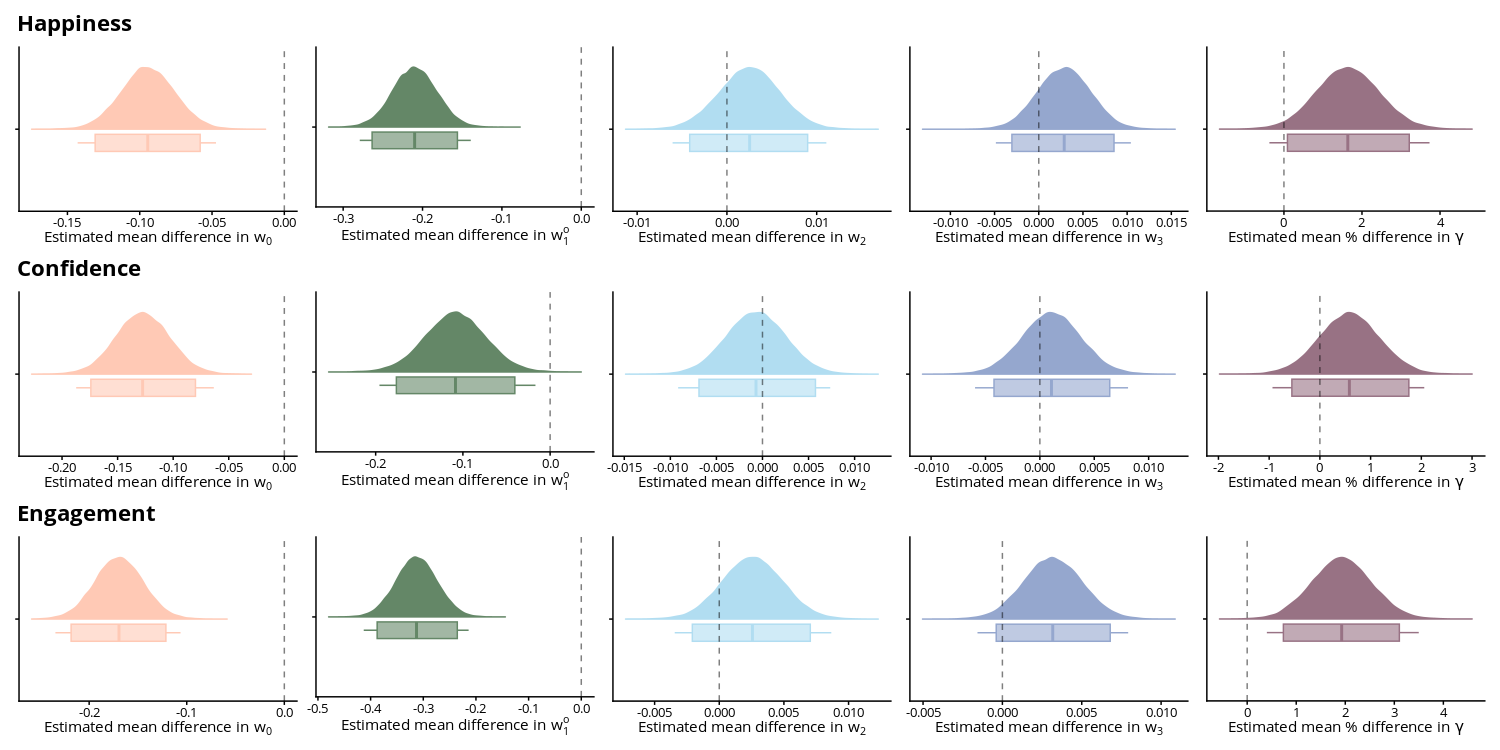

In [52]:
%%R -w 15 -h 7.5 --units in -r 100

fatigue_plt_happy <- pstpipeline::plot_glm(
  post_block_fatigue$happy, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
fatigue_plt_conf <- pstpipeline::plot_glm(
  post_block_fatigue$confident, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
fatigue_plt_bored <- pstpipeline::plot_glm(
  post_block_fatigue$engaged, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

fatigue_plt_happy / fatigue_plt_conf / fatigue_plt_bored

Perhaps unsurprisingly, self-reported post-block fatigue is strongly negatively associated with both $w^o_1$ and $w^b_1$ across all three affect ratings. In addition, it is also strongly associated with baseline ratings for all three affect adjectives, though it should be noted there is limited evidence of an strong positive association between any of the factor scores and post-block fatigue ($r$=0.05-0.11), the effects of which on $w_0$ appear independent of fatigue.

### Association between *change* in post-block fatigue ratings and model parameters

Note that we also control for mean overall fatigue ratings here, as clearly baseline fatigue and interpretations of the scale will differ.

In [53]:
%%R
post_block_fatigue_change <- list()

post_block_fatigue_change$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 1,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue_change$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 2,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue_change$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_4wt),
  raw_df = list(raw_df_4wt),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 3,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.3 seconds.
Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 6.9 seconds.
Chain 1 finished in 7.4 seconds.
Chain 2 finished in 7.5 seconds.
Chain 4 finished in 8.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.6 seconds.
Total execution time: 9.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.3 seconds.
Chain 4 finished in 7.8 seconds.
Chain 2 finished in 8.5 seconds.
Chain 3 finished in 8.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 8.0 seconds.
Total execution time: 9.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 7.2 seconds.
Chain 4 finished in 7.0 seconds.
Chain 2 finished in 8.3 seconds.
Chain 1 finished in 8.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.8 seconds.
Total execution time: 8.8 seconds.


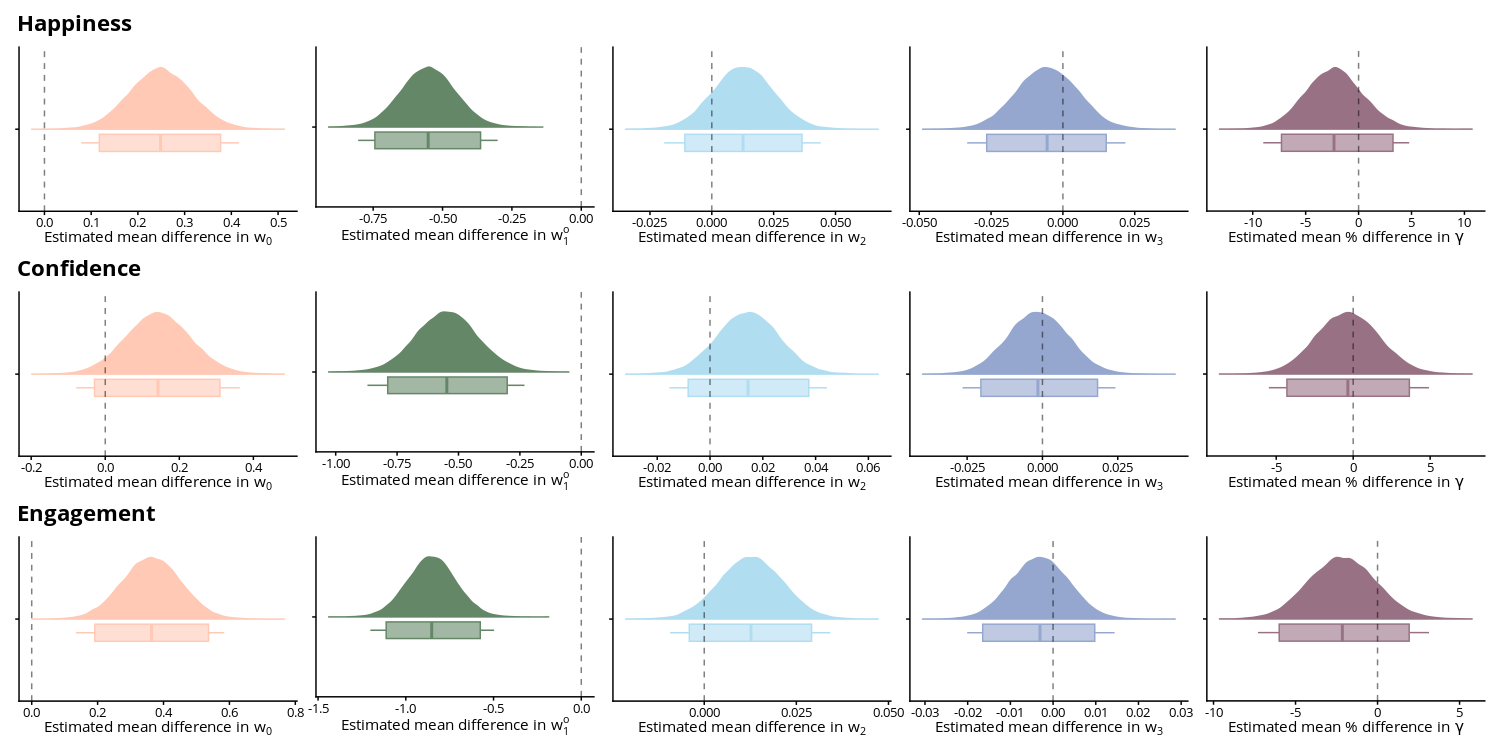

In [54]:
%%R -w 15 -h 7.5 --units in -r 100

fatigue_change_plt_happy <- pstpipeline::plot_glm(
  post_block_fatigue_change$happy, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
fatigue_change_plt_conf <- pstpipeline::plot_glm(
  post_block_fatigue_change$confident, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
fatigue_change_plt_bored <- pstpipeline::plot_glm(
  post_block_fatigue_change$engaged, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

fatigue_change_plt_happy / fatigue_change_plt_conf / fatigue_change_plt_bored

Indeed, as suspected, there is a negative assocaition between change in post-block fatigue (i.e., where positive coefficients = more tired at the end of the block) and $w^o_1$. In addition, interestingly, increased declines were associated with higher baseline affect, especially engagement which may perhaps represent an effect of motivation - participants who were more motivated and engaged towards the beginning of the task also exerted more effort throughout the task, resulting in greater overall increases in fatigue and decreases in affect.

In [55]:
%%R
explore_fatigue <- list()
explore_fatigue$post_block_fatigue <- post_block_fatigue
explore_fatigue$post_block_fatigue_change <- post_block_fatigue_change

saveRDS(explore_fatigue, "outputs/cmdstan/affect_2a/outcome_glms/exploratory_fatigue_models.RDS")